In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
2200/3

733.3333333333334

In [3]:
(761 * 3) + 50

2333

In [4]:
# Import Biopython modules to interact with KEGG
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

import pandas as pd
import numpy as np
from functools import reduce

from src.visualization.plots import HR_GENE_SET, NHEJ_GENE_SET, FANCONI_ANEMIA_GENE_SET
from src.config import get_common_barcodes, HOME_PATH, get_hussmann_supplementary_xlsx, get_experiment_artifacts


MIN_RANKED_DSB_GENE = 3000
T = "isGODSBRepair"

if T == "isGORepair":
    MIN_RANKED_DSB_GENE = 3000
    NUM_PROMISING_GENES = 450
else:
    MIN_RANKED_DSB_GENE = 13000
    # NUM_PROMISING_GENES = 410 # initial setting
    NUM_PROMISING_GENES = 454 # expanded setting

In [5]:
final_genes = pd.read_csv("../outlier_detection/artifacts/final_gene_list.tsv", sep="\t", usecols=[0, 5, 6], skiprows=1)[1:].rename(columns={"Measure": "Gene"})
final_genes.head()

,Gene,Rank,Pseudo-control
1,Atp6v1g1,1.0,False
2,H2ac18,2.0,False
3,Metap2,3.0,False
4,Xrcc5,4.0,False
5,H2ax,5.0,False


In [6]:
results_f = get_experiment_artifacts() + "/augmented_with_GO_outlier_results.pkl"
full_results_df = pd.read_pickle(results_f)
results_f

'/Users/colm/repos/MUSICian/notebooks/exploratory/outlier_detection/artifacts/paired-replicates.robust_cov.700//augmented_with_GO_outlier_results.pkl'

In [7]:
final_genes = final_genes.set_index("Gene").join(full_results_df[[("Global", T)]].droplevel(axis=1, level=0))

In [8]:
nonGODSBRepair = final_genes[~final_genes[T]]
listA = nonGODSBRepair[:NUM_PROMISING_GENES].index.to_series()
listA.shape

(454,)

In [9]:
GODSBRepair = final_genes[final_genes[T]]
listB = GODSBRepair[GODSBRepair["Rank"] < MIN_RANKED_DSB_GENE].index.to_series()
listB.shape

(254,)

In [10]:
all_hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)
all_hussmann_repair_genes = all_hussmann_repair_genes["Gene"].str.lower().str.capitalize().dropna()
all_hussmann_repair_genes.shape[0]

476

In [11]:
hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)
hussmann_repair_genes = hussmann_repair_genes["Gene.1"].str.lower().str.capitalize().dropna()
most_active_hussmann_genes = np.intersect1d(hussmann_repair_genes, final_genes.index)
missing_hussmann_genes = list(set(hussmann_repair_genes) - set(most_active_hussmann_genes))
most_active_hussmann_genes = final_genes.loc[list(np.intersect1d(final_genes.index, most_active_hussmann_genes))+ ["Wapl", "Sem1", "H2ax", "Abraxas1", "Faap24", "Trp53bp1"]]
most_active_hussmann_genes

,Rank,Pseudo-control,isGODSBRepair
Gene,,,
Aptx,3648.0,False,True
Ascc3,5404.0,False,False
Atm,247.0,False,True
Atr,6777.0,False,True
Atrip,1958.0,False,False
...,...,...,...
Sem1,112.0,False,True
H2ax,5.0,False,True
Abraxas1,1666.0,False,True


In [12]:
print(", ".join(missing_hussmann_genes).upper())

SSBP1, H2AFX, TP53BP1, DTL, DUT, C19ORF40, NHEJ1, SHFM1, FANCE, FAM175A, WAPAL


- Could not find another name for "NHEJ1" that was in our list. See Xlf and cernunnos
- Could not find another name for "FANCE". Also tried Face
----------
- "WAPAL" should be Wapl
- "SHFM1" should be Sem1
- "H2AFX" shuld be H2ax
- "FAM175A" should be Abraxas1
- "C19ORF40" should be Faap24
- "TP53BP1" should be Trp53bp1
----------
- "Dut" sgRNAs were filtered out at the QA stage.
- "Ssbp1" filtered out at QA stage
- "DTL" filtered out at QA stage

In [13]:
from src.visualization.plots import NHEJ_GENE_SET, HR_GENE_SET, FANCONI_ANEMIA_GENE_SET

listC = np.unique(pd.Series(most_active_hussmann_genes[most_active_hussmann_genes["Rank"] < MIN_RANKED_DSB_GENE].index.to_list() \
                            + ["Dut", "Ssbp1", "Dtl", "Nhej1", "Fance"] + NHEJ_GENE_SET + HR_GENE_SET + FANCONI_ANEMIA_GENE_SET))
listC.shape

(155,)

In [14]:
from functools import reduce

candidates = reduce(np.union1d, (listA, listB, listC))
candidates.shape

(761,)

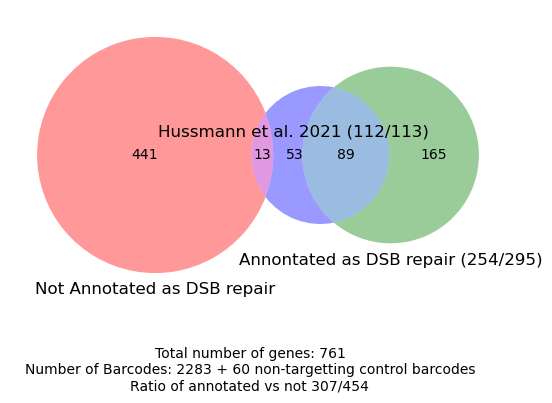

In [15]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

vd = venn3([set(listA), set(listB), set(listC)], ["Not Annotated as DSB repair", "Annontated as DSB repair ({}/{})".format(len(listB), GODSBRepair.shape[0]), "Hussmann et al. 2021 ({}/{})".format(np.intersect1d(listC, most_active_hussmann_genes.index).shape[0], most_active_hussmann_genes.shape[0])])

txt="Total number of genes: {}\nNumber of Barcodes: {} + 60 non-targetting control barcodes\nRatio of annotated vs not {}/{}".format(candidates.shape[0], candidates.shape[0]*3, candidates.shape[0]-len(listA), len(listA))
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

lbl = vd.get_label_by_id("C")
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.4))

plt.show()

isGORepair
False         417
True           37
dtype: int64


Text(0.5, 1.0, "Annotated as ''repair'' in GO")

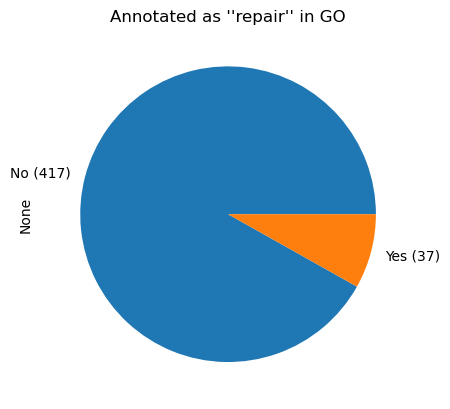

In [16]:

pie_df = full_results_df[[("Global", "isGORepair")]].droplevel(axis=1, level=0).loc[listA].value_counts()
print(pie_df)
pie_df.plot.pie(labels=["No ({})".format(pie_df.iloc[0]), "Yes ({})".format(pie_df.iloc[1])])

plt.title("Annotated as ''repair'' in GO")



Text(0.5, 1.0, 'In Hussmann et al 2021')

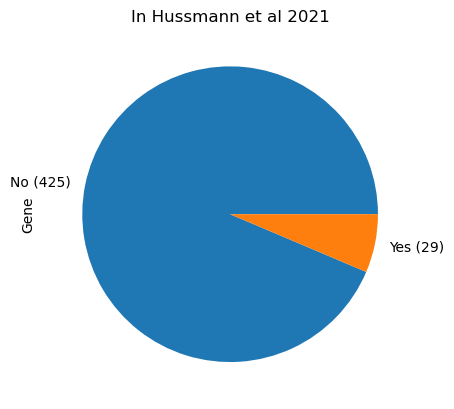

In [17]:
pie_df = full_results_df[[("Global", "isGORepair")]].droplevel(axis=1, level=0).loc[listA].index.to_series().isin(all_hussmann_repair_genes).value_counts()

pie_df.plot.pie(labels=["No ({})".format(pie_df.iloc[0]), "Yes ({})".format(pie_df.iloc[1])])

plt.title("In Hussmann et al 2021")

In [27]:
full_results_df[[("Global", "isGODDR")]]

Sample  Measure
Global  isGODDR    66
dtype: int64

Text(0.5, 1.0, "Annotated as ''damage response'' in GO")

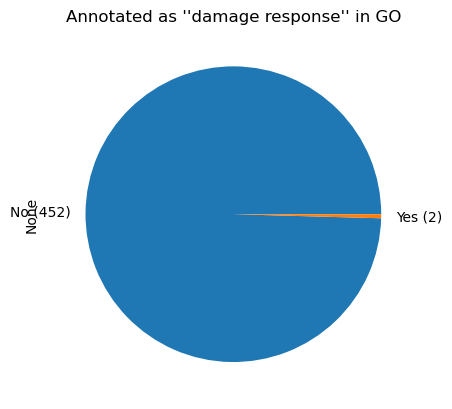

In [28]:
pie_df = full_results_df[[("Global", "isGODDR")]].droplevel(axis=1, level=0).loc[listA].value_counts()

pie_df.plot.pie(labels=["No ({})".format(pie_df.iloc[0]), "Yes ({})".format(pie_df.iloc[1])])

plt.title("Annotated as ''damage response'' in GO")

Text(0.5, 1.0, 'Histogram of ranks of Hussmann gene set')

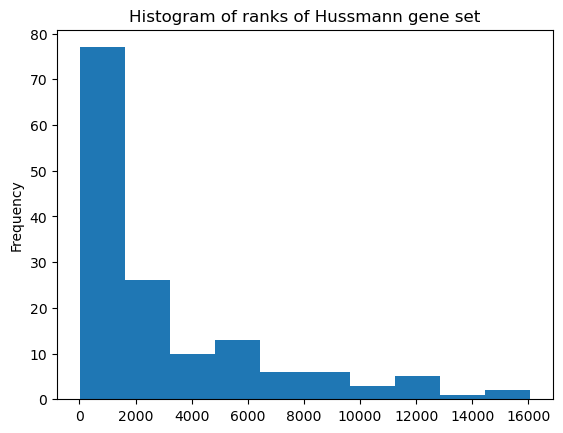

In [19]:
final_genes.loc[np.intersect1d(listC, final_genes.index), "Rank"].plot.hist()
plt.title("Histogram of ranks of Hussmann gene set")

In [20]:
candidate_details = final_genes.loc[np.intersect1d(candidates, final_genes.index), ["Rank"]]
candidate_details["Not Annotated"] = candidate_details.index.to_series().apply(lambda x: x in listA)

In [21]:
candidate_details[candidate_details["Not Annotated"]]["Rank"].max()

500.0

In [22]:
candidates.shape[0]

761

In [23]:
np.savetxt("artifacts/candidates.txt", candidates, delimiter=",", fmt='%s')

In [24]:
from src.visualization.plots import HR_GENE_SET, FANCONI_ANEMIA_GENE_SET, NHEJ_GENE_SET

In [25]:
def print_details(pathway):
    print("included")
    included_list = list(np.intersect1d(pathway, candidates))
    print(" ".join(included_list))
    print(len(included_list))

    print("excluded")
    excluded_list = list(set(pathway) - set(candidates))
    print(" ".join(excluded_list))
    print(len(excluded_list))

print("HR")
print_details(HR_GENE_SET)
print("FA")
print_details(FANCONI_ANEMIA_GENE_SET)
print("NHEJ")
print_details(NHEJ_GENE_SET)

HR
included
Abraxas1 Atm Babam1 Babam2 Bard1 Blm Brca1 Brca2 Brcc3 Brcc3dc Brip1 Eme1 Mre11a Mus81 Nbn Palb2 Pold1 Pold2 Pold3 Pold4 Rad50 Rad51 Rad51b Rad51c Rad51d Rad52 Rad54b Rad54l Rbbp8 Rpa1 Rpa2 Rpa3 Sem1 Ssbp1 Sycp3 Top3a Top3b Topbp1 Uimc1 Xrcc2 Xrcc3
41
excluded

0
FA
included
Atr Atrip Blm Brca1 Brca2 Brip1 Cenps Cenpx Eme1 Eme2 Ercc1 Ercc4 Faap100 Faap24 Fan1 Fanca Fancb Fancc Fancd2 Fance Fancf Fancg Fanci Fancl Fancm Hes1 Mlh1 Mus81 Palb2 Pms2 Polh Poli Polk Poln Rad51 Rad51c Rev1 Rev3l Rmi1 Rmi2 Rpa1 Rpa2 Rpa3 Slx1b Slx4 Telo2 Top3a Top3b Ube2t Usp1 Wdr48
51
excluded

0
NHEJ
included
Dclre1c Dntt Fen1 Lig4 Mre11a Nhej1 Poll Polm Prkdc Rad50 Xrcc4 Xrcc5 Xrcc6
13
excluded

0
